In [1]:
import numpy as np
import sys
import torch
sys.path.append('..')
from functools import partial
from matplotlib import pyplot as plt
from prob_mbrl import train_regressor
from prob_mbrl.losses import gaussian_log_likelihood
from prob_mbrl.models import mlp, dropout_mlp, BDropout, CDropout, Regressor, Swish, Sin, SinLU
from prob_mbrl.utils import iterate_minibatches
torch.set_num_threads(2)

In [2]:
# build model
n_layers = 4
drop_rate = 0.1
model = Regressor(
    dropout_mlp(
        1, 2, [200]*n_layers, nonlin=Swish,
        weights_initializer=partial(torch.nn.init.xavier_normal_,
                                    gain=1.0),#torch.nn.init.calculate_gain('relu')),
        biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
        dropout_layers=[CDropout(drop_rate, temperature=0.1)]*n_layers))


# optimizer
params = filter(lambda p: p.requires_grad, model.parameters())
opt = torch.optim.Adam(params, 1e-3, amsgrad=True)
N_ensemble = 100

In [3]:
# create training dataset
def f(x):
    return sum([np.sin(-2*np.pi*(2*k-1)*x)/(2*k-1) for k in range(1, 3)])

train_x = np.concatenate([np.arange(-0.6,-0.25,0.001), np.arange(0.1,0.25,0.001), 2*np.arange(0.65,1.0,0.001),
                          np.arange(0.65,1.0,0.001)])
train_y = f(train_x)
train_y += 0.01*np.random.randn(*train_y.shape)
X = torch.from_numpy(train_x[:, None])
Y = torch.from_numpy(train_y[:, None])

model.set_dataset(X, Y)
model = model.float().cuda()

In [7]:
train_regressor(model, iters=2000, batchsize=N_ensemble, resample=False, optimizer=opt)

log-likelihood of data: 0.890268: 100%|█████████▉| 1997/2000 [00:43<00:00, 45.68it/s]


In [8]:
test_x = np.arange(-0.8,2.3,0.05)
ret = []
#model.model.resample()
for i, x in enumerate(test_x):
    x = torch.tensor(x[None]).float().cuda()
    outs = model(x.expand((N_ensemble, 1)), resample=False)
    y = torch.cat(outs, 1)
    ret.append(y.cpu().detach().numpy())
    torch.cuda.empty_cache()
ret = np.stack(ret)
ret = ret.transpose(1, 0, 2)
torch.cuda.empty_cache()
import gc
for i in range(3):
    gc.collect()

Text(0,0.5,'$f(s_t, a_t) - s_t$')

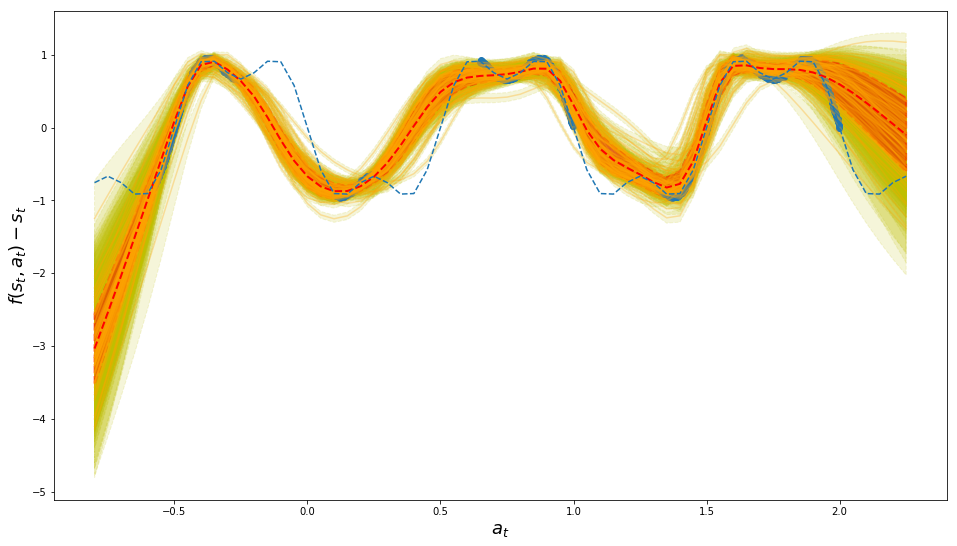

In [9]:
plt.figure(figsize=(16,9))
for i in range(len(ret)):
    m, S = ret[i, :, 0], ret[i, :, 1]
    #print S
    plt.plot(test_x, m, label='nn%d' % i, color='orange', alpha=0.3)
    plt.fill_between(test_x, m-S, m+S, alpha=0.15, color='y', linestyle='--')
    #plt.fill_between(test_x, m-2*S, m+2*S, alpha=0.075, color='y', linestyle='--')
m = ret[:, :, 0].mean(0)
S = ret[:, :, 0].std(0)
plt.plot(test_x, m, label='nn%d' % i, color='red', linestyle='--', linewidth=2)
plt.fill_between(test_x, m-S, m+S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.5)
#plt.fill_between(test_x, m-2*S, m+2*S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.25)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$a_t$', fontsize=18)
plt.ylabel('$f(s_t, a_t) - s_t$', fontsize=18)
#plt.legend()

Text(0,0.5,'$f(s_t, a_t) - s_t$')

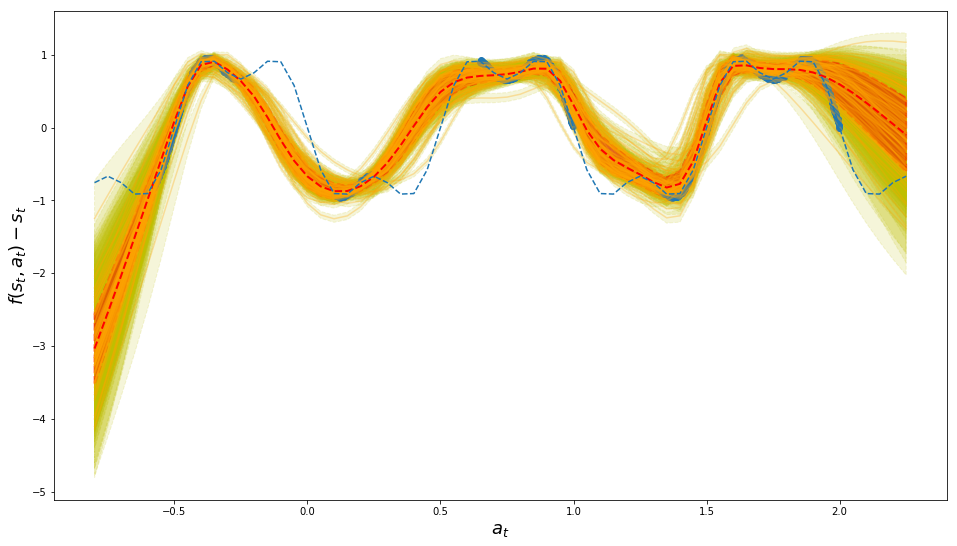

In [10]:
plt.figure(figsize=(16,9))
for i in range(len(ret)):
    m, S = ret[i, :, 0], ret[i, :, 1]
    #print S
    plt.plot(test_x, m, label='nn%d' % i, color='orange', alpha=0.3)
    plt.fill_between(test_x, m-S, m+S, alpha=0.15, color='y', linestyle='--')
    #plt.fill_between(test_x, m-2*S, m+2*S, alpha=0.075, color='y', linestyle='--')
m = ret[:, :, 0].mean(0)
S = ret[:, :, 0].std(0)
plt.plot(test_x, m, label='nn%d' % i, color='red', linestyle='--', linewidth=2)
plt.fill_between(test_x, m-S, m+S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.5)
#plt.fill_between(test_x, m-2*S, m+2*S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.25)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$a_t$', fontsize=18)
plt.ylabel('$f(s_t, a_t) - s_t$', fontsize=18)
#plt.legend()

tensor(0.9713, device='cuda:0')

In [1]:
X.m

NameError: name 'X' is not defined

In [4]:
import  torch

In [7]:
torch.nn.functional.threshold(0, X, 1)

TypeError: threshold(): argument 'input' (position 1) must be Tensor, not int